In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import Dense,Input,LSTM,GlobalMaxPooling1D,Embedding,MaxPooling1D,Conv1D,Concatenate,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob


In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

# With data augmentation 

In [4]:
!wget --passive-ftp --prefer-family=ipv4 --ftp-user datasets@mmspgdata.epfl.ch  --ftp-password ohsh9jah4T -nc ftp://tremplin.epfl.ch//FoodImage/Food-5K.zip

--2022-09-19 16:13:02--  ftp://tremplin.epfl.ch//FoodImage/Food-5K.zip
           => ‘Food-5K.zip’
Resolving tremplin.epfl.ch (tremplin.epfl.ch)... 128.178.218.41, 2001:620:618:1da:7:80b2:da01:3
Connecting to tremplin.epfl.ch (tremplin.epfl.ch)|128.178.218.41|:21... connected.
Logging in as datasets@mmspgdata.epfl.ch ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /FoodImage ... done.
==> SIZE Food-5K.zip ... 446919921
==> PASV ... done.    ==> RETR Food-5K.zip ... done.
Length: 446919921 (426M) (unauthoritative)

Food-5K.zip         100%[===================>] 426.22M  16.5MB/s    in 27s     

2022-09-19 16:13:45 (15.8 MB/s) - ‘Food-5K.zip’ saved [446919921]



In [5]:
!unzip -qq -o Food-5K.zip

In [6]:
!ls

evaluation  Food-5K.zip  __MACOSX  sample_data	training  validation


In [ ]:
!ls training

Ci serve una cartella per ogni classe, è evidente però che 0 e 1 definiscono classi diverse

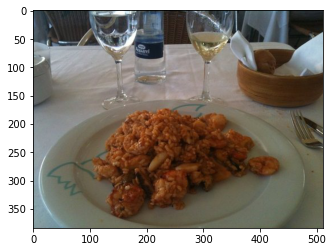

In [8]:
plt.imshow(image.load_img('training/1_1189.jpg'))

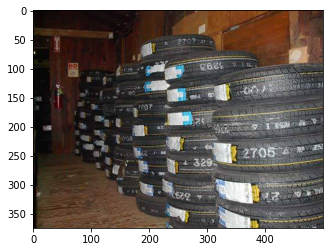

In [9]:

plt.imshow(image.load_img('training/0_400.jpg'))

In [10]:
!mkdir data
!mkdir data/train
!mkdir data/validation 

!mkdir data/train/food
!mkdir data/train/non_food

!mkdir data/validation/food
!mkdir data/validation/non_food


!mv training/1* data/train/food
!mv training/0* data/train/non_food

!mv validation/1* data/validation/food
!mv validation/0* data/validation/non_food

In [11]:
train_path= "data/train"
valid_path="data/validation"

In [12]:
IMAGE_SIZE=[200,200]

image_files=glob(train_path+'/*/*.jpg')
valid_image_files=glob(valid_path+'/*/*.jpg')

folders=glob(train_path+'/*')
folders

['data/train/food', 'data/train/non_food']

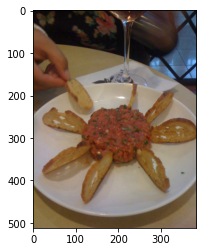

In [13]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [26]:
print(IMAGE_SIZE+[3])

[200, 200, 3]


In [14]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

58900480/58889256 [==============================] - 0s 0us/step


In [15]:
ptm.trainable=False

In [16]:
K = len(folders)
x= Flatten()(ptm.output)
x=Dense(K,activation='softmax')(x) # può anche gestire il caso K = 2


In [17]:
model = Model(inputs=ptm.input,outputs=x)


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [19]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen=ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)
batch_size=128
train_generator=gen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

valid_generator=gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
) # poiché il generator genera i target come one hot encoding matrici di default si pouò usare questa al posto della sparse categorical

In [21]:
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=int(np.ceil(len(image_files)/batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files)/batch_size))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
24/24 [==============================] - 83s 3s/step - loss: 1.6294 - accuracy: 0.9220 - val_loss: 0.9219 - val_accuracy: 0.9610
Epoch 2/10
24/24 [==============================] - 60s 3s/step - loss: 0.4881 - accuracy: 0.9760 - val_loss: 1.0279 - val_accuracy: 0.9560
Epoch 3/10
24/24 [==============================] - 52s 2s/step - loss: 0.1995 - accuracy: 0.9897 - val_loss: 0.7523 - val_accuracy: 0.9700
Epoch 4/10
24/24 [==============================] - 53s 2s/step - loss: 0.3097 - accuracy: 0.9817 - val_loss: 1.2638 - val_accuracy: 0.9580
Epoch 5/10
24/24 [==============================] - 52s 2s/step - loss: 0.2109 - accuracy: 0.9867 - val_loss: 0.9255 - val_accuracy: 0.9670
Epoch 6/10
24/24 [==============================] - 52s 2s/step - loss: 0.2673 - accuracy: 0.9863 - val_loss: 0.6607 - val_accuracy: 0.9620
Epoch 7/10
24/24 [==============================] - 52s 2s/step - loss: 0.1902 - accuracy: 0.9903 - val_loss: 0.6538 - val_accuracy: 0.9730
Epoch 8/10
24/24 [==

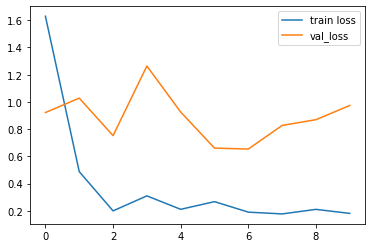

In [22]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

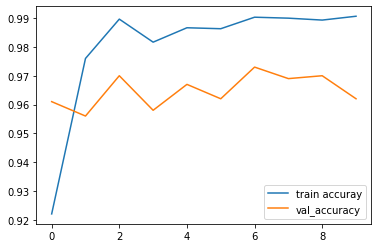

In [23]:
plt.plot(r.history['accuracy'],label='train accuray')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()